In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from munch import Munch
from scipy.linalg import eigvalsh

from QO.general import vec2
from QO.hamiltonians import eigs_over_k

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

from QO.thermodynamics import GCP_contributions, GCP

## The point of this one is to try 

In [2]:
def k_space_H(t, k, L, U = 0, **kwargs):
    """
         | -2 t_y cos(k_y - l*phi), -t_x, ...     exp(-ik_xL) |
         | -t_x, .                                            |
     H = | 0   ,                                              |
         | .                                                  |
         | exp(ik_xL)  .....                                  |


    """
    phi = 2*np.pi / L.x

    #the factor of two along the diagonal comes from  adding the upper and lower triangle together
    upper_triangle = np.diag(U/2 - t.y * np.cos(k.y - np.arange(L.x)*phi), k = 0) \
        - t.x *   np.diag(np.ones(L.x-1), k =  1) \
        + np.exp(-1j * k.x * L.x) * np.diag([1,], k = L.x-1) \
    
    #make hermitian
    H = upper_triangle + upper_triangle.conj().T
    
    return H


def disordered_coupling(A, B, coupling = 0):
    """
    Construct a block hamiltonian from two NxN blocks corresponding to subsystems A and B

    H = |A Y|
        |Y B|

    """
    N = A.shape[0]
    Y = np.diag(np.random.normal(loc = 0, scale = coupling/2, size = N))
    return np.block([[A, Y],
                     [Y, B]])


min_phi, max_phi = (0.006283185307179587, 0.3141592653589793)
min_L_x, max_L_x = (3.0, 160.0)


Doing a sweep over L_x producing a sweep over B

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

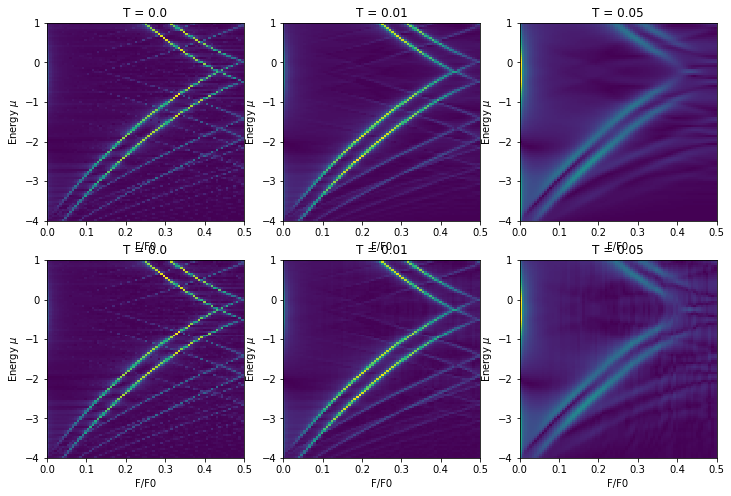

In [3]:
from itertools import count

min_phi, max_phi = np.pi / 500, np.pi / 10
min_L_x, max_L_x = np.floor(1 / max_phi), np.ceil(1 / min_phi)

print(f"""
min_phi, max_phi = {min_phi, max_phi}
min_L_x, max_L_x = {min_L_x, max_L_x}
""")
L_x = np.arange(min_L_x, max_L_x, dtype = int)

print(f"""
Doing a sweep over L_x producing a sweep over B
""")

params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(4, 4),
)  

bins = np.linspace(-5,5,200)
Mus = np.linspace(-4,1,100)
Ts = np.array([0,0.01,0.05])
Repeats = np.arange(30)

mu = -1

B = np.pi / L_x
dB = np.diff(B)
N = len(B)
offset = -0.5

GCPs = np.zeros([len(Repeats), 2, len(Mus), len(L_x), len(Ts)])

for m in Repeats:
    for n, coupling in enumerate([0, 0.05]):
        def H_function(t, k, L):
            return disordered_coupling(k_space_H(t, k, L), k_space_H(t, k, L, U = offset), coupling)

        for i, lx in enumerate(L_x):
            print('.', end = '')
            eigs = eigs_over_k(H_function, L = vec2(lx, 1), **params)

            for j, mu in enumerate(Mus):
                for k, T in enumerate(Ts):
                    GCPs[m, n, j, i, k] = GCP(eigs, mu, T)

GCPs = GCPs.mean(axis = 0)


f, axes = plt.subplots(nrows = 2, ncols = len(Ts), figsize = (12,8))

for n, coupling in enumerate([0, 0.05]):
    for k, T in zip(count(), Ts):
        dGCP = np.diff(GCPs[n, :, :, k], axis = -1)

        M = - dGCP / dB


        freqs = np.fft.rfftfreq(M.shape[-1])
        ffts = np.fft.rfft(M, axis = -1)
        print(M.shape, Mus.shape, ffts.shape, freqs.shape)
    
        ax = axes[n, k]
        ax.pcolormesh(freqs, Mus, np.abs(ffts))

        ax.set(ylabel = "Energy $\mu$", xlabel = "F/F0")
        ax.set(title = f'T = {T}')
    
print(f"""
min_phi, max_phi = {min_phi, max_phi}
min_L_x, max_L_x = {min_L_x, max_L_x}
N = {N}

coupling = {coupling}
offset = {offset}
""")


min_phi, max_phi = (0.006283185307179587, 0.3141592653589793)
min_L_x, max_L_x = (3.0, 160.0)
N = 157

coupling = 0.05
offset = -0.5



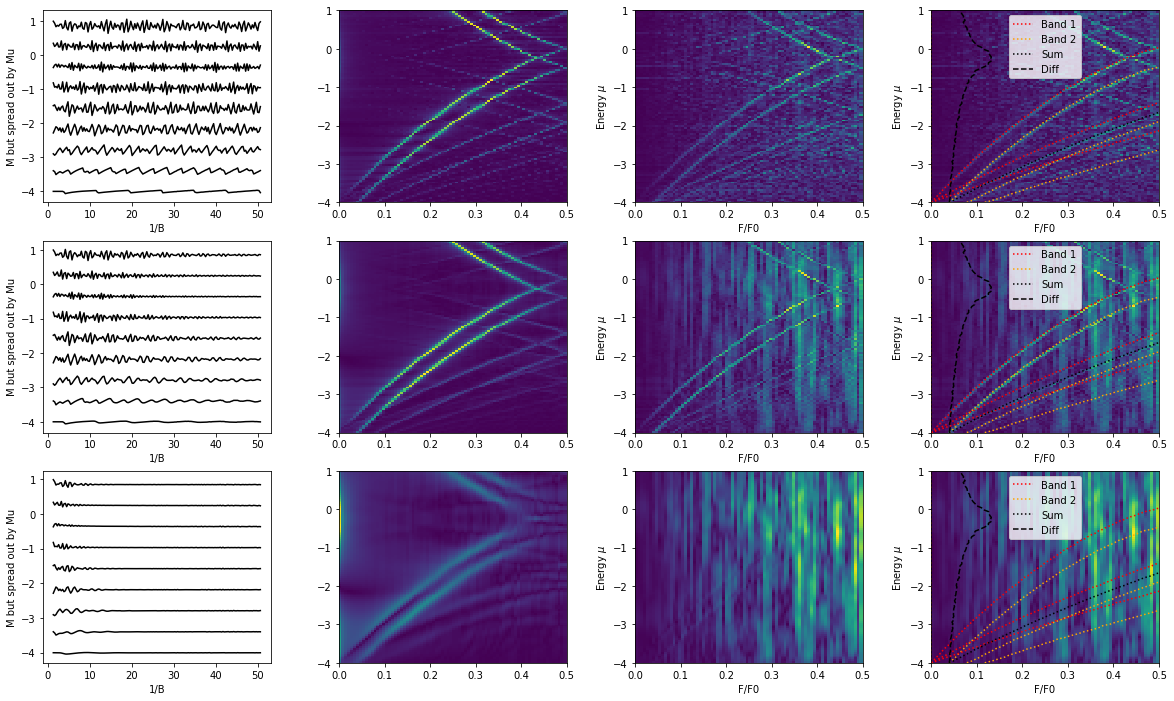

In [5]:
from QO.hamiltonians import FS_area, lattice_dispersion

f, plot_axes = plt.subplots(ncols = 4, nrows = len(Ts), figsize = (20,4*len(Ts)), gridspec_kw = dict(wspace = 0.3))

N = len(B)


for k, T, axes in zip(count(), Ts, plot_axes):
    dGCP = np.diff(GCPs[:, :, :, k], axis = -1)
    M = - dGCP / dB
    
    freqs = np.fft.rfftfreq(M.shape[-1])
    ffts = np.fft.rfft(M[1], axis = -1)
    clean_ffts = np.fft.rfft(M[0], axis = -1)

    for j in range(0, len(Mus), 12):
        mu = Mus[j]
        axes[0].plot(B[1:]**-1, M[1, j] + mu, label = f"$\mu$ = {mu}", color = 'k')
    
    axes[1].pcolormesh(freqs, Mus, np.abs(ffts))
    axes[2].pcolormesh(freqs, Mus, np.abs(ffts - clean_ffts))
    axes[3].pcolormesh(freqs, Mus, np.abs(ffts - clean_ffts))

    harmonics = 4
    pred = [_,_]
    for m in range(harmonics):
        for i, offset, color in zip([0,1], [0, -0.5], ["r", "orange"]):
            pred[i], = axes[3].plot(m*FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = color,
                             linestyle = "dotted")

    s, = axes[3].plot(FS_area(lattice_dispersion, vec2(100,100), Mus) +
                        FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = 'k',
                         linestyle = "dotted")

    d, = axes[3].plot(-FS_area(lattice_dispersion, vec2(100,100), Mus) +
                            FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = 'k',
                             linestyle = "--")

    axes[0].set(ylabel = "M but spread out by Mu", xlabel = "1/B")
    axes[2].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))
    axes[3].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))

    
    axes[3].legend([pred[0], pred[1], s, d], ["Band 1", "Band 2", "Sum", "Diff"])

print(f"""
min_phi, max_phi = {min_phi, max_phi}
min_L_x, max_L_x = {min_L_x, max_L_x}
N = {N}

coupling = {coupling}
offset = {offset}
""")
f.savefig("two_band.png")